# Import data and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

tree_data = pd.read_csv('../../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(tree_data.head())

Nan values in dataset: 0
   Elevation  Aspect  Slope  Horizontal_To_Hydrology  Vertical_To_Hydrology  \
0       2596      51      3                      258                      0   
1       2590      56      2                      212                     -6   
2       2804     139      9                      268                     65   
3       2785     155     18                      242                    118   
4       2595      45      2                      153                     -1   

   Horizontal_To_Roadways  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                     510            221             232            148   
1                     390            220             235            151   
2                    3180            234             238            135   
3                    3090            238             238            122   
4                     391            220             234            150   

   Horizontal_To_Fire  ...  Soil_Type_31  Soil_Ty

## Split training/testing data

In [100]:
x_tree = tree_data.drop('Cover_Type', axis=1)
y_tree = tree_data['Cover_Type']

x_train, x_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2)


x_underSampled, y_underSampled = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_train, y_train)

x_underSampled, y_underSampled = x_train, y_train

x_underSampled = x_underSampled.to_numpy()
y_underSampled = y_underSampled.to_numpy()

data = tree_data.to_numpy()

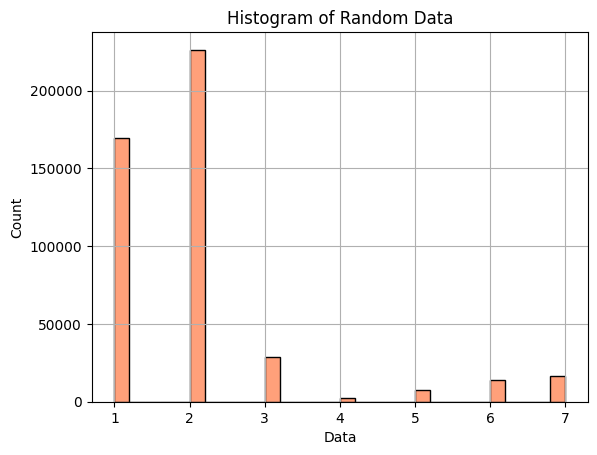

In [101]:
plt.hist(y_underSampled, bins=30, color='lightsalmon', edgecolor='black')
plt.xlabel('Data')
plt.ylabel('Count')
plt.title('Histogram of Random Data')
plt.grid(True)
plt.show()


## Z Scaling Dataset

In [102]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_zScaled_train, x_zScaled_test, y_zScaled_train, y_zScaled_test = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

## Min Max Scaled Dataset

In [103]:
scaler = MinMaxScaler()
dataScaled = scalar.fit_transform(x_underSampled[:,:54])

x_minMaxScaled_train, x_minMaxScaled_test, y_minMaxScaled_train, y_minMaxScaled_test = train_test_split(dataScaled, y_underSampled, test_size=0.2)


## L2 Scaled Dataset

In [104]:
data_scaled = np.linalg.norm(x_underSampled[:,:54])

x_l2Scaled_train, x_l2Scaled_test, y_l2Scaled_train, y_l2Scaled_test = train_test_split(dataScaled, y_underSampled, test_size=0.2)

## AdaBoost

In [108]:

ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100)
ab.fit(x_zScaled_train, y_zScaled_train.ravel())
print("Z Scaled Test Accuracy: ", ab.score(x_zScaled_test, y_zScaled_test))


Z Scaled Test Accuracy:  0.959585637142058


In [109]:

ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100)
ab.fit(x_minMaxScaled_train, y_minMaxScaled_train.ravel())
print("Z Scaled Test Accuracy: ", ab.score(x_minMaxScaled_test, y_minMaxScaled_test))

Z Scaled Test Accuracy:  0.960069705901336


In [110]:

ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100)
ab.fit(x_l2Scaled_train, y_l2Scaled_train.ravel())
print("Z Scaled Test Accuracy: ", ab.score(x_l2Scaled_test, y_l2Scaled_test))

Z Scaled Test Accuracy:  0.9599728921494805


## GridSearch

In [98]:
from sklearn.model_selection import GridSearchCV

param_grid = {"estimator": [DecisionTreeClassifier(max_depth=7), DecisionTreeClassifier(max_depth=9), \
                            DecisionTreeClassifier(max_depth=11), DecisionTreeClassifier(max_depth=13)], \
"n_estimators": [25, 50, 75, 100]}

model_ab = AdaBoostClassifier()

grid_searchAB1 = GridSearchCV(model_ab, param_grid, cv=3, scoring="accuracy", verbose=10)
grid_searchAB2 = GridSearchCV(model_ab, param_grid, cv=3, scoring="accuracy", verbose=10)
grid_searchAB3 = GridSearchCV(model_ab, param_grid, cv=3, scoring="accuracy", verbose=10)
grid_searchAB1.fit(x_zScaled_train, y_zScaled_train.ravel())
grid_searchAB2.fit(x_minMaxScaled_train, y_minMaxScaled_train.ravel())
grid_searchAB3.fit(x_l2Scaled_train, y_l2Scaled_train.ravel())

print(grid_searchAB1.best_params_, grid_searchAB1.best_score_)
print(grid_searchAB2.best_params_, grid_searchAB2.best_score_)
print(grid_searchAB3.best_params_, grid_searchAB3.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 1/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.874 total time=   8.9s
[CV 2/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 2/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.875 total time=   8.8s
[CV 3/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 3/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.875 total time=   8.8s
[CV 1/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.874 total time=  17.6s
[CV 2/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 2/16] END estimator=DecisionTreeClassifier(max_dep

NameError: name 'grid_searchLAB1' is not defined

## Saved output

In [ ]:
"""Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 1/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.874 total time=   8.9s
[CV 2/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 2/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.875 total time=   8.8s
[CV 3/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 3/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.875 total time=   8.8s
[CV 1/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.874 total time=  17.6s
[CV 2/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.865 total time=  17.4s
[CV 3/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.872 total time=  17.3s
[CV 1/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 1/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.880 total time=  26.3s
[CV 2/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 2/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.888 total time=  26.2s
[CV 3/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 3/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.889 total time=  26.3s
[CV 1/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 1/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.885 total time=  35.1s
[CV 2/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 2/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.894 total time=  35.2s
[CV 3/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 3/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.894 total time=  35.1s
[CV 1/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 1/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.926 total time=  11.2s
[CV 2/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 2/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.929 total time=  11.2s
[CV 3/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 3/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.927 total time=  11.1s
[CV 1/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 1/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.940 total time=  22.4s
[CV 2/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 2/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.939 total time=  22.3s
[CV 3/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 3/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.936 total time=  22.2s
[CV 1/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 1/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.942 total time=  33.6s
[CV 2/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 2/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.945 total time=  33.3s
[CV 3/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 3/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.945 total time=  33.3s
[CV 1/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 1/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.945 total time=  45.2s
[CV 2/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 2/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.951 total time=  44.8s
[CV 3/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 3/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.950 total time=  44.5s
[CV 1/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 1/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.964 total time=  13.7s
[CV 2/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 2/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.960 total time=  13.6s
[CV 3/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 3/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.963 total time=  13.6s
[CV 1/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 1/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.969 total time=  27.2s
[CV 2/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 2/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.969 total time=  27.1s
[CV 3/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 3/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.968 total time=  27.0s
[CV 1/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 1/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.971 total time=  40.8s
[CV 2/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 2/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.971 total time=  40.5s
[CV 3/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 3/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.972 total time=  40.5s
[CV 1/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 1/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.973 total time=  54.2s
[CV 2/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 2/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.973 total time=  54.2s
[CV 3/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 3/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.974 total time=  53.9s
[CV 1/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 1/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.972 total time=  15.9s
[CV 2/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 2/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.972 total time=  15.8s
[CV 3/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 3/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.971 total time=  15.8s
[CV 1/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 1/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.975 total time=  31.9s
[CV 2/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 2/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.974 total time=  31.6s
[CV 3/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 3/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.974 total time=  31.8s
[CV 1/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 1/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.975 total time=  47.6s
[CV 2/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 2/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.976 total time=  47.5s
[CV 3/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 3/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.976 total time=  47.4s
[CV 1/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 1/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.976 total time= 1.1min
[CV 2/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 2/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.976 total time= 1.1min
[CV 3/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 3/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.976 total time= 1.1min
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 1/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.872 total time=   8.9s
[CV 2/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 2/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.862 total time=   8.8s
[CV 3/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 3/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.886 total time=   8.8s
[CV 1/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.874 total time=  17.6s
[CV 2/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.886 total time=  17.9s
[CV 3/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.885 total time=  17.5s
[CV 1/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 1/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.888 total time=  26.2s
[CV 2/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 2/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.874 total time=  26.3s
[CV 3/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 3/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.888 total time=  26.3s
[CV 1/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 1/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.886 total time=  34.9s
[CV 2/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 2/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.888 total time=  34.8s
[CV 3/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 3/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.887 total time=  35.1s
[CV 1/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 1/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.926 total time=  11.2s
[CV 2/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 2/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.927 total time=  11.1s
[CV 3/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 3/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.926 total time=  11.1s
[CV 1/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 1/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.944 total time=  22.2s
[CV 2/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 2/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.935 total time=  22.2s
[CV 3/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 3/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.933 total time=  22.3s
[CV 1/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 1/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.944 total time=  33.4s
[CV 2/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 2/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.943 total time=  33.3s
[CV 3/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 3/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.944 total time=  33.3s
[CV 1/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 1/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.951 total time=  44.5s
[CV 2/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 2/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.944 total time=  44.3s
[CV 3/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 3/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.948 total time=  44.4s
[CV 1/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 1/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.962 total time=  13.5s
[CV 2/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 2/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.960 total time=  13.4s
[CV 3/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 3/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.963 total time=  13.5s
[CV 1/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 1/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.970 total time=  27.1s
[CV 2/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 2/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.967 total time=  27.1s
[CV 3/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 3/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.968 total time=  27.0s
[CV 1/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 1/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.971 total time=  40.6s
[CV 2/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 2/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.969 total time=  40.6s
[CV 3/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 3/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.972 total time=  40.7s
[CV 1/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 1/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.974 total time=  54.2s
[CV 2/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 2/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.972 total time=  54.3s
[CV 3/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 3/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.974 total time=  54.1s
[CV 1/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 1/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.973 total time=  15.8s
[CV 2/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 2/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.972 total time=  15.8s
[CV 3/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 3/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.971 total time=  15.8s
[CV 1/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 1/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.975 total time=  31.8s
[CV 2/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 2/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.972 total time=  31.6s
[CV 3/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 3/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.975 total time=  31.8s
[CV 1/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 1/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.976 total time=  47.9s
[CV 2/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 2/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.974 total time=  47.8s
[CV 3/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 3/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.976 total time=  48.1s
[CV 1/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 1/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.977 total time= 1.1min
[CV 2/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 2/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.975 total time= 1.1min
[CV 3/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 3/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.976 total time= 1.1min
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 1/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.862 total time=   9.2s
[CV 2/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 2/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.879 total time=   9.2s
[CV 3/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 3/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.874 total time=   9.1s
[CV 1/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.890 total time=  18.3s
[CV 2/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.885 total time=  18.2s
[CV 3/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 2/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.870 total time=  18.2s
[CV 1/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 1/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.880 total time=  27.3s
[CV 2/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 2/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.878 total time=  27.2s
[CV 3/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 3/3; 3/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75;, score=0.890 total time=  27.0s
[CV 1/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 1/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.890 total time=  35.2s
[CV 2/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 2/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.885 total time=  35.0s
[CV 3/3; 4/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 3/3; 4/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.889 total time=  35.2s
[CV 1/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 1/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.927 total time=  11.3s
[CV 2/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 2/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.922 total time=  11.3s
[CV 3/3; 5/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25
[CV 3/3; 5/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=25;, score=0.924 total time=  11.3s
[CV 1/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 1/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.939 total time=  22.6s
[CV 2/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 2/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.941 total time=  23.0s
[CV 3/3; 6/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50
[CV 3/3; 6/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=50;, score=0.939 total time=  22.6s
[CV 1/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 1/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.942 total time=  34.1s
[CV 2/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 2/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.943 total time=  34.0s
[CV 3/3; 7/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75
[CV 3/3; 7/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=75;, score=0.945 total time=  33.8s
[CV 1/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 1/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.945 total time=  44.8s
[CV 2/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 2/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.949 total time=  44.7s
[CV 3/3; 8/16] START estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100
[CV 3/3; 8/16] END estimator=DecisionTreeClassifier(max_depth=9), n_estimators=100;, score=0.950 total time=  45.0s
[CV 1/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 1/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.961 total time=  13.6s
[CV 2/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 2/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.963 total time=  13.6s
[CV 3/3; 9/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25
[CV 3/3; 9/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=25;, score=0.962 total time=  13.6s
[CV 1/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 1/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.970 total time=  27.3s
[CV 2/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 2/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.969 total time=  27.2s
[CV 3/3; 10/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50
[CV 3/3; 10/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=50;, score=0.969 total time=  27.2s
[CV 1/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 1/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.973 total time=  41.0s
[CV 2/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 2/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.971 total time=  40.9s
[CV 3/3; 11/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75
[CV 3/3; 11/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=75;, score=0.971 total time=  40.8s
[CV 1/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 1/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.973 total time=  54.6s
[CV 2/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 2/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.973 total time=  54.4s
[CV 3/3; 12/16] START estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100
[CV 3/3; 12/16] END estimator=DecisionTreeClassifier(max_depth=11), n_estimators=100;, score=0.973 total time=  54.5s
[CV 1/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 1/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.972 total time=  15.9s
[CV 2/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 2/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.971 total time=  15.8s
[CV 3/3; 13/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25
[CV 3/3; 13/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=25;, score=0.971 total time=  15.9s
[CV 1/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 1/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.975 total time=  32.0s
[CV 2/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 2/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.974 total time=  31.7s
[CV 3/3; 14/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50
[CV 3/3; 14/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=50;, score=0.975 total time=  31.7s
[CV 1/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 1/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.975 total time=  47.7s
[CV 2/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 2/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.975 total time=  47.6s
[CV 3/3; 15/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75
[CV 3/3; 15/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=75;, score=0.975 total time=  47.7s
[CV 1/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 1/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.976 total time= 1.1min
[CV 2/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 2/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.975 total time= 1.1min
[CV 3/3; 16/16] START estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100
[CV 3/3; 16/16] END estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100;, score=0.977 total time= 1.1min
"""

In [ ]:
"""{'estimator': DecisionTreeClassifier(max_depth=13), 'n_estimators': 100} 0.9760202178270415
{'estimator': DecisionTreeClassifier(max_depth=13), 'n_estimators': 100} 0.9760774255510927
{'estimator': DecisionTreeClassifier(max_depth=13), 'n_estimators': 100} 0.9760462260070902"""